In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

#get columns
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

[('2017-08-23',)]
[('2016-08-23',)]


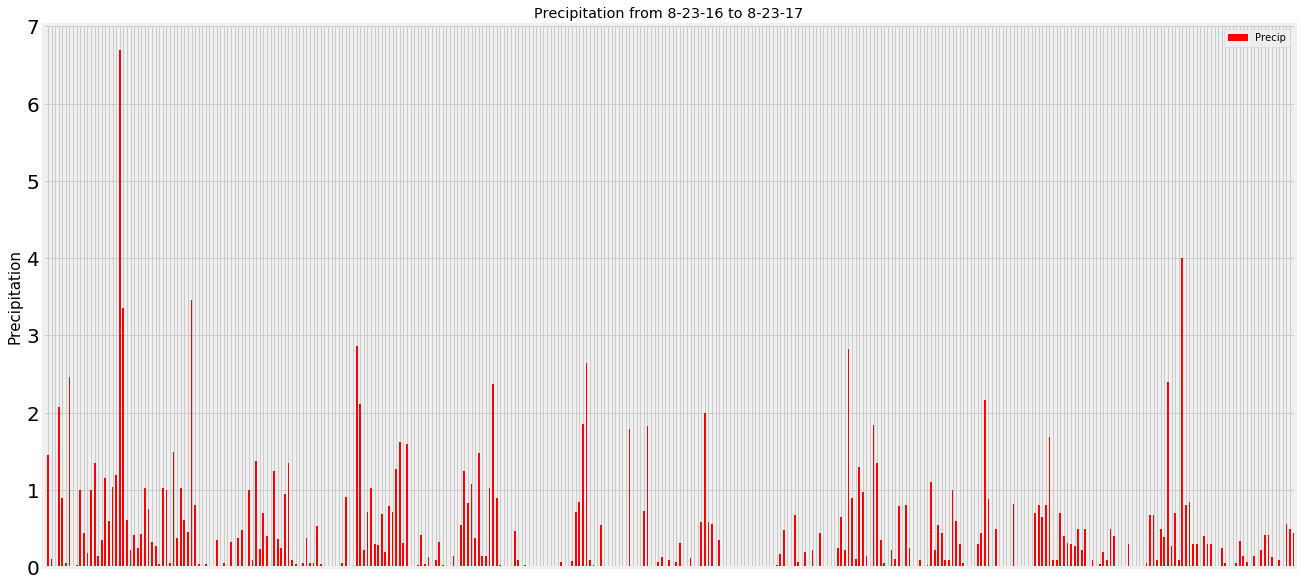

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = db.select([Measurement.date])
ResultProxy = connection.execute(query)
ResultSet = ResultProxy.fetchall()
last_date = ResultSet[-1:] # last date
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
year_from = ResultSet[-349:-348]
print(year_from)
# Perform a query to retrieve the data and precipitation scores
query2 = db.select([Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs])
ResultProxy2 = connection.execute(query2)
ResultSet2 = ResultProxy2.fetchall()
last_year = ResultSet2[-349:]
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year)
last_year_df.columns = ['Date', 'Station', 'Precip', 'Tobs']
last_year_df.set_index(["Date"])
last_year_df.head()

# Sort the dataframe by date
last_year_df.sort_values(by=['Date'])
# Use Pandas Plotting with Matplotlib to plot the data
ax = last_year_df[["Precip"]].plot(kind='bar', title='Precipitation from 8-23-16 to 8-23-17', figsize=(20,10), color='red', fontsize=20)
ax.set_ylabel("Precipitation",fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.savefig('precipitation_bar.png')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,Precip,Tobs
count,328.000000,349.000000
mean,0.450640,72.091691
std,0.717174,3.762743
min,0.000000,58.000000
25%,0.010000,70.000000
50%,0.190000,72.000000
75%,0.610000,75.000000
max,6.700000,82.000000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
print(stations)

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc

active_stations = session.query(Measurement.station, db.func.count()).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).\
    all()

for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest =  session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281')
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281')
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281')

for result in lowest:
    print(result)
for result in highest:
    print(result)
for result in average:
    print(result)

(54.0,)
(85.0,)
(71.66378066378067,)


             Date  Temp      Station
14954  2017-08-14  77.0  USC00519281
14955  2017-08-15  77.0  USC00519281
14956  2017-08-16  76.0  USC00519281
14957  2017-08-17  76.0  USC00519281
14958  2017-08-18  79.0  USC00519281
             Date  Temp      Station
14602  2016-08-18  80.0  USC00519281


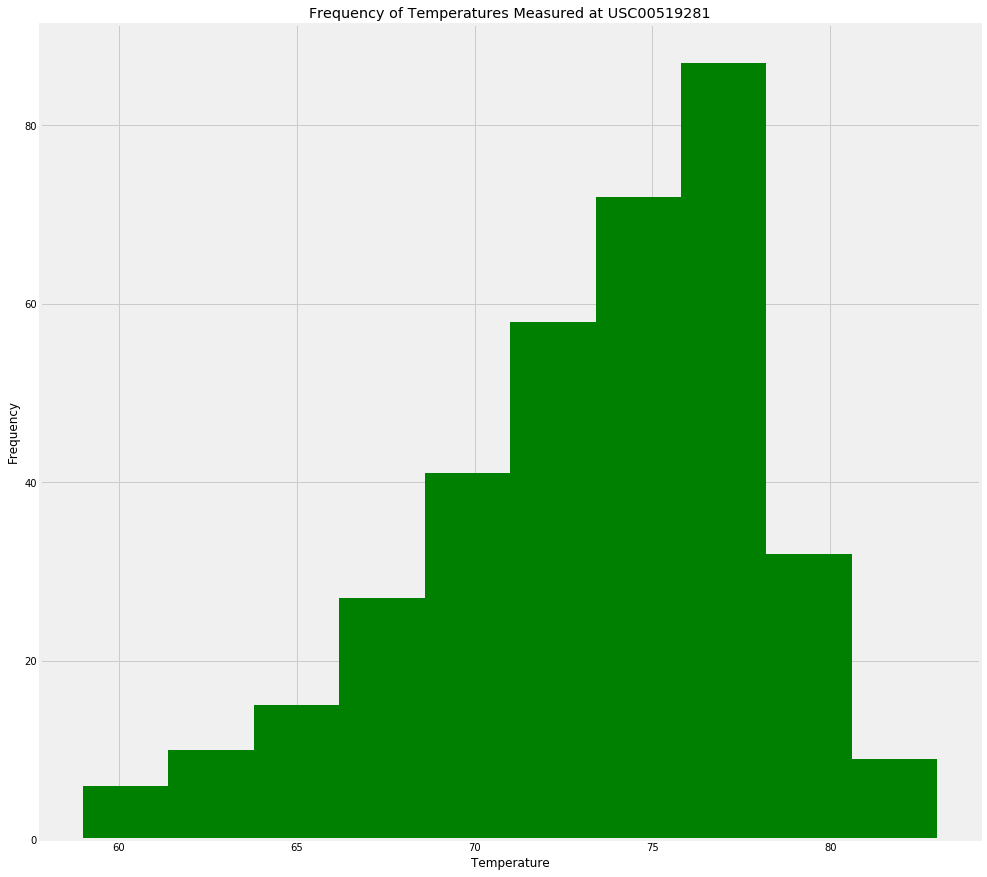

In [41]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query3 = db.select([Measurement.date, Measurement.tobs, Measurement.station])
ResultProxy3 = connection.execute(query3)
ResultSet3 = ResultProxy3.fetchall()
result_df = pd.DataFrame(ResultSet3)
result_df.columns = ['Date', 'Temp', 'Station']

USC00519281 = result_df.loc[result_df['Station'] == 'USC00519281']
USC00519281_df = pd.DataFrame(USC00519281)
print(USC00519281_df.tail())
twelve_ago = USC00519281_df.loc[USC00519281_df['Date'] == '2016-08-18']
print(twelve_ago)
last_twelve = USC00519281_df.loc[14602:]
last_twelve_df = pd.DataFrame(last_twelve)

fig = plt.figure(figsize=(15,15))
plt.hist(last_twelve_df.Temp, color = "green")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Frequency of Temperatures Measured at USC00519281")

plt.savefig('temp_freq_hist.png')

plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-02-28', '2017-03-05'))

[(59.0, 74.11674478057094, 84.0)]


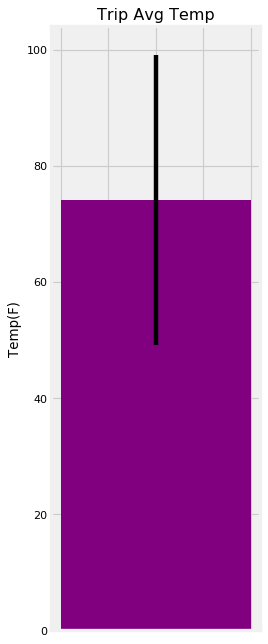

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3, 10), dpi=80)
position = 1
plt.bar(position, 74.12, color="purple", yerr=(84-59))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

plt.savefig('avg_temp.png')

plt.show()

In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip = db.text('''SELECT Measurement.station, Measurement.date, Measurement.prcp, 
    Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation
    FROM Measurement INNER JOIN Station on Station.station = Measurement.station
    ORDER BY Measurement.prcp DESC''')
results = connection.execute(trip).fetchall()
print(results)

[('USC00514830', '2014-07-20', 11.53, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519281', '2016-07-25', 9.64, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519281', '2011-01-13', 8.81, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', '2013-11-10', 8.06, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', '2014-07-20', 7.97, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00513117', '2016-07-25', 7.65, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00516128', '2015-09-15', 6.83, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', '2016-09-14', 6.7, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', '2011-12-13', 6.42, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)